<a id="1.Summary"></a>
# 1.Summary

- https://www.kaggle.com/c/google-quest-challenge
- BERT https://zhuanlan.zhihu.com/p/269516862

- 1.EDA
- 2.Preprocess data
- 3.Classify
- 4.

Typically, we have a Q&A dataset and there are 30+ columns `[0,1]` data coming from human evaluation.

<a id="2.Table of Contents"></a>
# 2.Tabole of Contents
<a href="#1.Summary">Click this Link back to Top</a>

<ol>
    <li><a href="#1.Summary">Summary</a></li>
    <li><a href="#2.Tabole of Contents">Tabole of Contents</a></li>
    <li><a href="#3.Import Packages">Import Packages</a></li>
    <li><a href="#4.Preprocess">Preprocess</a></li>
    <ul>
       <li><a href="#4.1 Import Data">4.1 Import Data</a></li>
       <li><a href="#4.2 Clean Data">4.2 Clean Data</a></li> 
    </ul>
    <li><a href="#5.EDA">EDA</a></li>
    <ul>
       <li><a href="#5.1 Model_A">5.1 Model_A</a></li>
       <li><a href="#5.2 Model_B">5.2 Model_B</a></li> 
       <li><a href="#5.3 Model_C">5.3 Model_C</a></li>
       <li><a href="#5.4 Split and Fit">5.4 Split and Fit</a></li>
       <li><a href="#5.5 Main_Function">5.5 Main_Function</a></li> 
       <li><a href="#5.6 Plot and Analysis">5.6 Plot and Analysis</a></li> 
    </ul>
    <li><a href="#6.Task 3: Fight overfitting">Task 3: Fight overfitting</a></li>
    <ul>
       <li><a href="#6.1 Model B1 (Dropout)">6.1 Model B1 (Dropout)</a></li>
       <li><a href="#6.2 Model B2 (L2)">6.2 Model B2 (L2)</a></li> 
       <li><a href="#6.3 Model B3 (Dropout+L2)">6.3 Model B3 (Dropout+L2)</a></li>
       <li><a href="#6.4 Fit">6.4 Fit</a></li> 
       <li><a href="#6.5 Plot and Analysis">6.5 Plot and Analysis</a></li> 
    </ul>
    <li><a href="#7.Task 4: NN for regression task">Task 4: NN for regression task</a></li>
    <li><a href="#8.Task 5: NN for multi-classification task">Task 5: NN for multi-classification task</a></li>
    <li><a href="#9.Main Function">Main Function</a></li>
    <li><a href="#10.Unused Code">Unused Code</a></li>
</ol>

<br>

<a id="3.Import Packages"></a>
# 3.Import Packages
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [110]:
# most of data we will store in 
import pandas as pd
import numpy as np

# use regex to extract text
import re
# using copy to duplicate
import copy
# recording each step runing time
import time
# corpus will be string format
import string
# the easiest way to get text is using bs4 to get only text
from bs4 import BeautifulSoup
# make picture
import matplotlib.pyplot as plt
# draw picture
import seaborn as sns


# one of tokenize method
from sklearn.feature_extraction.text import TfidfVectorizer
# split data with random seed (37)
from sklearn.model_selection import train_test_split

# at EDA get Tokenizer info for deciding hyperparameters
from tensorflow.keras.preprocessing.text import Tokenizer
# add padding to a tokenized sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# input all the layers we might use 
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate, LSTM, GlobalAveragePooling1D
# do not use sequential to build model
from tensorflow.keras import Model
# need specify lr in optiizer
from tensorflow.keras import optimizers

import tensorflow as tf

<br>

<a id="4.Preprocess"></a>
# 4.Preprocess
<a href="#2.Table of Contents">Click this Link back to Top</a>

The list of 30 target labels are the same as the column names in the sample_submission.csv file. Target labels with the prefix <code>question_</code> relate to the <code>question_title</code> and/or <code>question_body</code> features in the data. Target labels with the prefix <code>answer_</code> relate to the <code>answer</code> feature.

<a id="4.1 Import Data"></a>
### 4.1 Import Data
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [87]:
class preprocess_data(object):
    """
    Because this data have two components, so we first preprocess it and then return raw and corpus to do EDA
    We also need to use preprocee to estimate hyperparameters
    """
    def __init__(self):
        None
    
    def import_data(self,path):
        """
        
        
        """
        # read the raw unpreprocess data into df_raw
        df_raw = pd.read_csv(path)
        # first we need extract the X(data) part and y(label) part.
        # In this dataset, columns from "qa_id" to "host" will be X(data)
        # columns from "question_asker_intent_understanding" to "answer_will_written" are human label result which is numerical betwenn [0,1]
        # 
        X_df = df_raw.iloc[:,0:10]
        y_df = df_raw.iloc[:,11:]
        
        # we classify question_title and question_body in X_question_df, question_ related columns into y_question_df, this is X y for one task
        # we classify answer in X_answer, answer_ related column into y_answer_df. This is X and y for another task
        # maybe we need sometime consider questoin and answer together
        # i believe user info have no contribution with this task
        # construct DataFrame 
        self.X_question_df = df_raw.loc[:,['qa_id', 'question_title', 'question_body','category','host']]
        self.X_answer_df = df_raw.loc[:,['qa_id','answer','category','host']]
        
        # initial label list
        y_question_list = []
        y_answer_list = []
        for idx, i in enumerate(y_df.columns):
            if "question_" in i:
                y_question_list.append(i)
            elif "answer_" in i:
                y_answer_list.append(i)
            else:
                continue
                
        # extract label of question
        self.y_question_df = df_raw[y_question_list]
        self.y_answer_df = df_raw[y_answer_list]
        # So, for now, we have two pair of dataset, firt is (X_question_df + y_question_df). Second is (X_answer_df + y_answer_df)
        
        #for question part, i think we need a new column for merge title and body, but we still reserve seperate column
        self.X_question_df['question'] = self.X_question_df['question_title'] + self.X_question_df['question_body']
        
        return df_raw, self.X_question_df, self.X_answer_df, self.y_question_df, self.y_answer_df

<a id="4.2 Clean Data"></a>
### 4.2 Clean Data
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [5]:
class clean_data(object):
    def __init__(self):
        """
        """
        None

    def clean_process(self, df, column_1, punctuation_fun = True, stopwords_fun = False):
        """
        I have reserve several interface and options to response different scenarios
        
        steps
        1.lowercase()
        2.remove special puncuation and symbol
        4.remove string puncuation
        5.only reserve words
        6.remove stop words(if we eliminate most frequcen word, do we still this? and did this affect LSTM?) so i put a switch

        Argus:
        -----
        df:DataFrame
            Input come from import_data() [column_1] is the columns that need corpus,
        column_1:string
            the name of column we need clean
        stopwrods_fun:boolen
            True, remove stopwords; False, do not remove stopwords


        Return:
        ------
        courpus_df:DataFrame
            Because we use apply(lambda) to process each cell in DataFrame, so output is still that DataFrame
        """
        print("*"*50,"Start Clean data", "*"*50)
        start_time = time.time()
        #original datatype is serise, first transfrom to string and get lower() case text
        corpus = df[column_1].str.lower()

        # Because we don't have html characters,we don't need this part
        # using bs4 to eliminate html
        #soup = BeautifulSoup(corpus_2, 'lxml')
        #corpus_3 = soup.get_text()
        corpus = corpus.apply(lambda x: self.remove_html(x))
        # any speical punctuation in filter sring should add "\" before it
        # This line is a compensation for remove_pun, if we puncturation_fun==False, which means we want to reserve some meanningfol
        # symbols, we can use this seperate function to remove those meaningless symbols
        corpus = corpus.apply(lambda x: self.remove_regex(x))

        # if punctuation_fun == True, we remove punctuation. 
        #In this step, further we maybe need seperate them to keep question mark for represent some meaning
        if punctuation_fun:
            # use sring.puncutation to eliminate, but we should first remove url. I believe this should be last step
            corpus = corpus.apply(lambda x: self.remove_pun(x))

        # this is last safeguard for clean_data process. This function literally only extract 
        # only reserve words
        pattern=r'[a-zA-Z][-._a-zA-Z]*[a-zA-Z]'
        corpus = [" ".join(re.findall(pattern, x)) for x in corpus]


        if stopwords_fun:
            # remove stop words
            corpus_list = []
            for sentence in tqdm(corpus_6):
                corpus_list.append(self.remove_stopwords(sentence))
    #         corpus_7 = corpus_6.apply(lambda x: remove_stopwords(x))
    #         corpus_7 = [remove_stopwords(x) for x in corpus_6]
            corpus = np.array(corpus_list)
            
#         # ********************improve strategy***************************** 
#         # due to this is very small, perhaps add stem and lemmanization will be better
#         # According to Pro Liu, this step is not necessary
#         # ********************improve strategy***************************** 
        
        
        #we sitll need to manipulate with index because it contain important relationship between corpus and claasify
        #list to pd.Series
#         corpus_8 = pd.Series(np.array(corpus))
        df['cleaned'] = pd.Series(np.array(corpus))

        cost_time = round((time.time()- start_time),4)
        print("*"*40,"End clean_data() with {} second".format(cost_time), "*"*40, end='\n\n')
        


        return df

    def remove_pun(self, text):
        """
        The reason i use seperate function is that pandas.apply can manipulate with column value. 
        If we use loop directly, we will get a join corpus without paragraph structure
        """
        no_pun = "".join([c for c in text if c not in string.punctuation])
        return no_pun

    def remove_html(self, text):
        """
        Use bs4 to extract text
        """
        soup = BeautifulSoup(text, 'lxml')
        no_html = soup.get_text()
        return no_html

    def remove_regex(self, text):
        """
        It was designed to remove special punctuation and character which we can't manipulate with string.puncutation effectively
        #             #!"#$%&()*\+,-./:;<=>\?@\[\\\]^_`{|}~\\t\\n\\r\“
        """
        #remove url
        no_reg = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
        #remove numbers
        no_reg = re.sub('\w*\d\w*', '', no_reg)
        return no_reg

    def remove_stopwords(self, sentence):
        stop_words_set = set(stopwords.words("english"))
        no_stopwords = " ".join([word for word in sentence.split(" ") if not word in stop_words_set])
    #     for word in text:
    #         if word not in stopwords.words("english"):
    #             output = output + " " + word
        return no_stopwords

<a id="5.EDA"></a>
# 5.EDA
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [100]:
class eda_data(object):
    """
    explorer this data structure
    """
    def __init__(self):
        """
        """
        # using distribution to decide this parameters
        self.MAX_SEQ_LENGTH = 300
        
        
    def question_plot(self, df):
        """
        Due to different column number, we need to 
        """
        #
        fig, axes = plt.subplots(7, 3, figsize=(18, 15))
        axes = axes.ravel()
        bins = np.linspace(0, 1, 20)

        for i, col in enumerate(df.columns):
            ax = axes[i]
            sns.histplot(df[col], label=col, kde=False, bins=bins, ax=ax)
            # ax.set_title(col)
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 6079])
        plt.tight_layout()
        plt.show()
        plt.close()
        


        
    def tokenize_plot(self, question_cleaned_df, answer_cleaned_df):
        """
        decide how many words should be left for tokenzie() function
        """
        # do not set num_words at first time and to see how many unique words we have 
        tokenizer_model = Tokenizer(split=' ', char_level=False, oov_token="<OOV>")
        # here is another trick, we need consider question and answer courpus into one unit
        # so we build a new big combination corpus
        corpus_sum = question_cleaned_df['cleaned'] + answer_cleaned_df['cleaned']
        # use previous model to fit this large combination corpus
        tokenizer_model.fit_on_texts(corpus_sum)
        # get the word_index and word_count dictionary
        # word_index is the number corresponding to words by frequence. word_count is the sepcific words appeart times frequency
        word_index, word_count = tokenizer_model.word_index, tokenizer_model.word_counts
        print(f"we got unique {len(word_index)} words")
        MAX_WORD=0
        for i in word_count.values():
            if i>5:
                MAX_WORD+=1
        print(f"we have {MAX_WORD} words appear more than 5 times")
        
                               
        #**************new tokenize process******************
        # start a new standard processs from begining
        tokenizer_new = Tokenizer(num_words = MAX_WORD, split=' ', char_level=False, oov_token="<OOV>")
        # fit on combination corpus
        tokenizer_new.fit_on_texts(corpus_sum)
        # get question of sequence
        question_seq = tokenizer_new.texts_to_sequences(question_cleaned_df['cleaned'])
        # get padded
        question_padded = pad_sequences(question_seq, padding='post', maxlen=self.MAX_SEQ_LENGTH, truncating='post')
        #**************new tokenize process******************
        question_cleaned_df['padded'] = list(question_padded)
        
        return question_padded, question_cleaned_df, word_index
    
    
    def label_feature(self, y_question_df):
        """
        In future, i will use arguritem to filter column. For now, i do it manually
        As i test use pure numerical algorithem to calcualte 
        """
        # first try these labels
        feature_cols = ['question_asker_intent_understanding',
                       'question_body_critical',
                       'question_expect_short_answer',
                       'question_interestingness_others'
                      ]
        y_label_df = y_question_df[feature_cols]
        return y_label_df

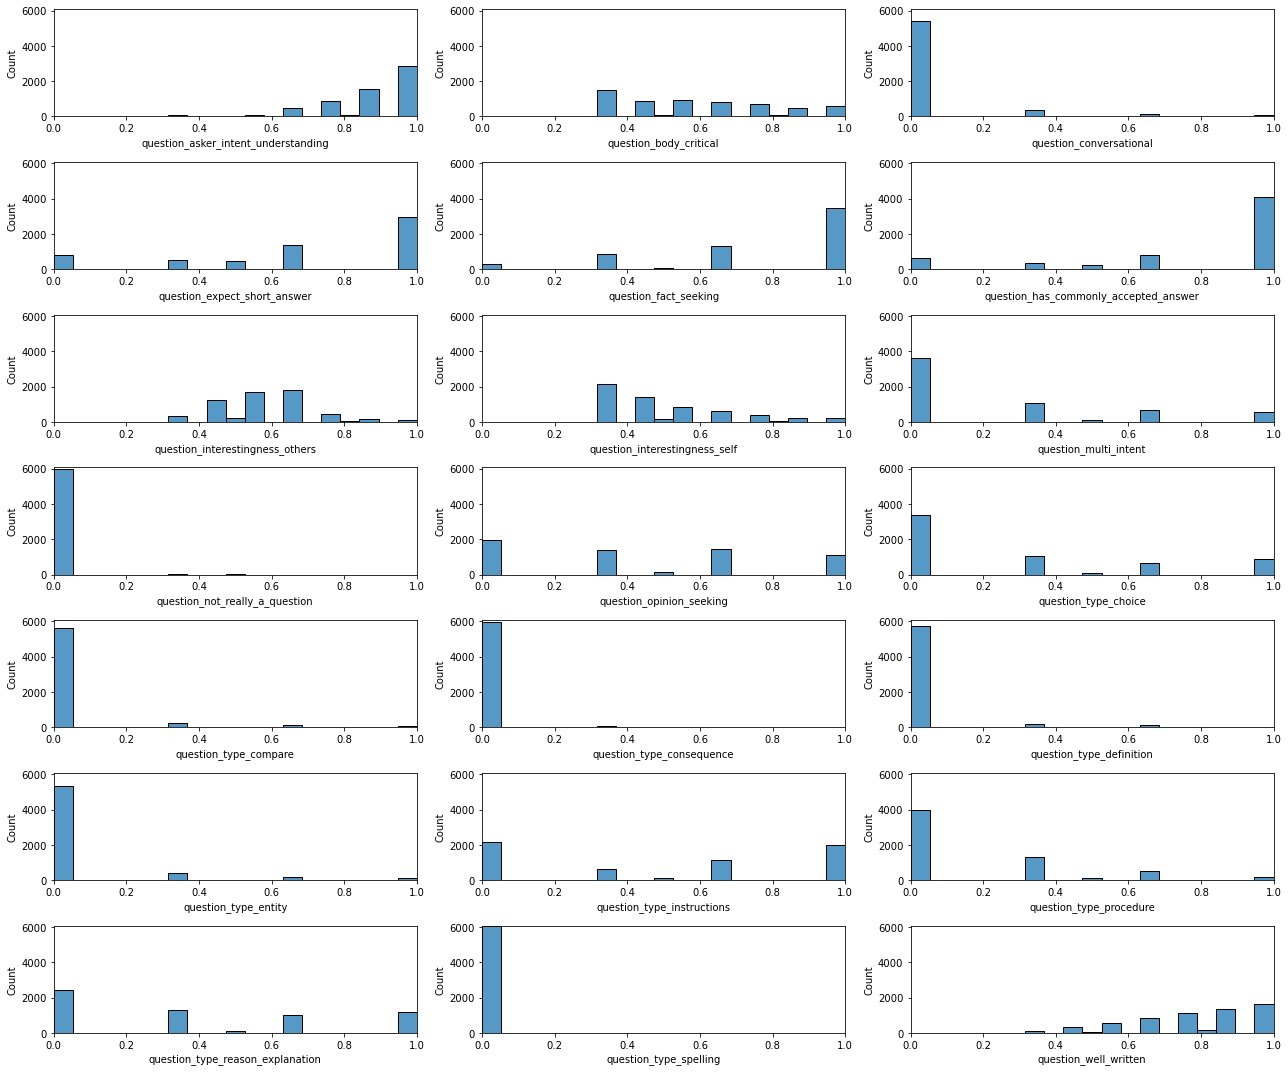

we got unique 72070 words
we have 13332 words appear more than 5 times


In [102]:
eda_class = eda_data()
eda_class.question_plot(y_question_df)
question_padded, question_cleaned_df, word_index = eda_class.tokenize_plot(question_cleaned_df, answer_cleaned_df)
y_label_df = eda_class.label_feature(y_question_df)

In [255]:
feature_cols = ['question_asker_intent_understanding',
               'question_body_critical',
               'question_expect_short_answer',
               'question_interestingness_others'
              ]

In [28]:
# y_question_df.loc[:,'labels'] = y_question_df.loc[:,feature_cols].apply(lambda x: ','.join(x.astype(str)),axis=1)

# y_question_df['labels'] = y_question_df[feature_cols].apply(lambda x: ','.join(x.astype(str)),axis=1)
# y_question_df

<a id="6.Multi-Tokenize"></a>
# 6.Multi-Tokenize
<a href="#2.Table of Contents">Click this Link back to Top</a>

There are seveal ways we can let model to learn how to provide score in each judgement

- 1.TFIDF ( if using max_df and min_df, perhaps not fit seq2seq generation model)
- 2.Embedding
- 3.GLOVE
- 4.LDA

TFIDF not word2vect, it just cacualte a numerical value for each word and concatenate into sentence to build a matrix

In [99]:
class tfidf_data(object):
    """
    """
    def __init__(self):
        """
        initial hyperparameters
        """
        # build a vocabulary that only consider the top max_features ordered by term frequency across the corpus. learned from EDA
        self.MAX_WORD = 13332
        
    def tfidf(df, vectorizer=None, to_cat= True):
        """
        Becuase we have to mentain 
        the relationship between corpus and his lable, we have several times list to DataFrame processes.
        I didn't show EDA part for setting up 

        Parameters:
        ------------
        df:pandas.DataFrame
            DataFrame, contain ['AUTHOR'] and ['CLASSIFY']. This is raw data.

        vectorizer:cofig
            When we apply to 

        Return:
        -------
        X_vector:array
            Dimension = (cleaned example, MAX_WORD).Cleaned data and transformed to TFIDF format 
            with original sequence, which means can be matched withcooresponding y_labels.

        y_vector:
            Dimension = (no. cleaned examples, NUM_LABELS)=(9630,3)


        """
        print("*"*50,"Start TFIDF transfrom", "*"*50)
        start_time = time.time()

         #*****************************cut down Part of optimization******************************************
    #     #we can't directly drop column because index will dynamicly decrease, but we can gather index of drop
    #     index_drop=[]
    #     #iteration through all DataFrame
    #     for i in range(len(df)):
    #         #according to plot and statitc result,>600 have 2628, <60 have 3540, so we only need 60<data<600
    #         if len(df.iloc[i,0])<60 or len(df.iloc[i,0])>600:
    #             #delete too big and too small
    #             index_drop.append(i)
    #     print(f"before drop shape={df.shape}")

    #     #drop row by list but remain old index number
    #     df = df.drop(index_drop,axis=0)
    #     print(f"after drop shape={df.shape}")
    #     #re.finall(\w+)  
    #     #*****************************cut down Part of optimization******************************************

        # inintial we need use vectorizer from train to process test data
        if vectorizer == None:
            vectorizer = TfidfVectorizer(sMAX_WORD='english', max_features = MAX_WORD)
            #when we built a vect, we need to import all words as corpus combination to generate a TFIDF dictornary
            vect = vectorizer.fit([" ".join(df['AUTHOR'].tolist())])
            #after fit, we need to use dictionary to transform our coupus into TFIDF(we can use sum() to check sparse)
            data_2 = vect.transform(df['AUTHOR']).toarray()
            X_vector = np.array(data_2)
        else:
            vect = vectorizer.fit([" ".join(df['AUTHOR'].tolist())])
            #after fit, we need to use dictionary to transform our coupus into TFIDF(we can use sum() to check sparse)
            X_vector = vect.transform(df['AUTHOR']).toarray()

        if to_categorical == True:
            #To remain the relation between AUTHOR vector and CLASSIFY labels, we also output y_vector coorespondingly
            y_vector = to_categorical(np.array(df['CLASSIFY']))
        else:
            y_vector = df['CLASSIFY']

        cost_time = round((time.time()- start_time),4)
        print("*"*40,"End tfidf() with {} second".format(cost_time), "*"*40, end='\n\n')

        return df, X_vector, y_vector, vect

Is that more robust if i divide 13332 for every value in vector dataset?

In [ ]:
chatbot
BLUE Rougue

In [7]:
# y_label_df.head(5)

<a id="6.8 Split Data"></a>
### 6.8 Split Data
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [90]:
def split_data(X_vector,y_vector, test_size=0.2):
    """
    this is only for padded data split
    """
    print("*"*50,"Start train_test_split", "*"*50)
    start_time = time.time()
    X_train, X_val, y_train, y_val = train_test_split(X_vector, y_vector, \
                                                        test_size=0.2, random_state=37)
    
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 37)
    
    cost_time = round((time.time()- start_time),4)
    print("*"*40,"End embedding() with {} seconds".format(cost_time), "*"*40, end='\n\n')
    return X_train, X_val, y_train, y_val

In [11]:
# X_train, X_test, X_val, y_train, y_test, y_val = split_data(question_padded,y_label_df, test_size=0.2)

In [12]:
# y_train.shape

<a id="7.Classify"></a>
# 7.Classify
<a href="#2.Table of Contents">Click this Link back to Top</a>

I will provide more than three type of input. All matrix will use number represent a whole sentence. What we can do include surpivsed learning to classify (NN, KNN) and unsurprivised learning to cluster (k-means + PCA)

<a id="7.1 KNN"></a>
### 7.1 KNN
<a href="#2.Table of Contents">Click this Link back to Top</a>

<a id="7.2 Neural Network Classify"></a>
### 7.2 Neural Network Classify
<a href="#2.Table of Contents">Click this Link back to Top</a>

tranform category to one-hot, last layer use softmax, use argmax() to get predict result

<a id="7.3 K-means cluster + PCA"></a>
### 7.3 K-means cluster + PCA
<a href="#2.Table of Contents">Click this Link back to Top</a>

Get high dimentsion cluster result and reduce dimenstion to get a 3D/2D visulization result

<a id="8.Models"></a>
# 8.Models
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [113]:
def nn_model(word_index):
    """
    Input is just padded question sequence, add Embedding layer transorfrom it into word vector and build up a sentence
    """
    #*************Hyperparameters************
    #max sequence/sentence length
    MAX_SEQ_LEN = 300
    # what is the word dimentsion for a single, for examplee, "thank" will have 
    EMBEDDING_DIM = 100
    #*************Hyperparameters************
    model = None
    
    
    input_layer_1 = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
    embed_layer_2 = Embedding(input_dim = len(word_index) + 1, \
                              output_dim = EMBEDDING_DIM, \
                              input_length=MAX_SEQ_LEN
                              )(input_layer_1)
    pooling_layer_3 = GlobalAveragePooling1D()(embed_layer_2)
    dense_layer_4 = Dense(units = 32, activation='relu')(pooling_layer_3)
    output_layer_5 = Dense(units = 4)(dense_layer_4)
    model = Model(inputs = input_layer_1, outputs = output_layer_5, name='nn_model')
    model.summary()
    return model
    

In [114]:
nn_model(word_index)

Model: "nn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 300, 100)          7207100   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 132       
Total params: 7,210,464
Trainable params: 7,210,464
Non-trainable params: 0
_________________________________________________________________


1.CNN(u-gim, bi, trigum = contcant)
2.CNN 
3.GRU
4.BERT

In [115]:
def compile_fit(model_input, X_train, X_val, y_train, y_val, loss_fun, epoch_num=3):
    """
    """
    start_time = time.time()
    print("*"*40,"Start {} Processing".format(model_input._name), "*"*40)
    
    model = model_input
#     METRICS = [
#           metrics.TruePositives(name='tp'),
#           metrics.FalsePositives(name='fp'),
#           metrics.TrueNegatives(name='tn'),
#           metrics.FalseNegatives(name='fn'), 
#           metrics.CategoricalAccuracy(name='accuracy'),
#           metrics.Precision(name='precision'),
#           metrics.Recall(name='recall'),
#           metrics.AUC(name='auc'),
#           F1Score(num_classes = int(y_train.shape[1]), name='F1')
#     ]

    learning_rate = 1e-2
    opt_adam = optimizers.Adam(lr = learning_rate, decay=1e-5)
    model.compile(loss=loss_fun, \
                  optimizer=opt_adam, \
                  metrics = ['mae','mse'])
    # batch_size is subjected to my GPU and GPU memory, after testing, 32 is reasonable value size. 
    # If vector bigger, this value should dercrease
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), \
                        epochs=epoch_num, batch_size=32, verbose =1)
    # dic = ['loss', 'accuracy', 'val_loss','val_accuracy']
    history_dict = [x for x in history.history]
    # model.predict(train_features[:10])

#     print("*"*50)
#     x_axis = list(range(epoch_num))
#     # loss
#     plt.plot(x_axis, history.history[history_dict[0]], color = 'r', lw = 2, label = history_dict[0])
#     # val_loss
#     plt.plot(x_axis, history.history[history_dict[10]], color = 'y', lw = 2, label = history_dict[10])
#     # accuracy
#     plt.plot(x_axis, history.history[history_dict[5]], color = 'b', lw = 2, label = history_dict[5])
#     # validataion_accuracy
#     plt.plot(x_axis, history.history[history_dict[15]], color = 'k', lw = 2, label = history_dict[15])
#     plt.title(model_input._name)
#     plt.legend()
#     plt.xlabel('Epochs')
#     # plt.ylabel(str(dic[i]))
#     plt.show()
    
    cost_time = round((time.time()- start_time),4)
    print("*"*40,"End {} with {} seconds".format(model_input._name, cost_time), "*"*40, end='\n\n')
    return history, model

In [116]:
X_train.shape

(4863, 300)

In [119]:
# history, model_2 = compile_fit(nn_model(), X_train, X_test, X_val, y_train, y_test, y_val, loss_fun = 'binary_crossentropy', epoch_num=50)
history, model_2 = compile_fit(nn_model(word_index), X_train, X_val, y_train, y_val, loss_fun = 'mse', epoch_num=10)

Model: "nn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 300, 100)          7207100   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 100)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_60 (Dense)             (None, 4)                 132       
Total params: 7,210,464
Trainable params: 7,210,464
Non-trainable params: 0
_________________________________________________________________
**************************************** Start nn_model Processing ****************************************
Train 

<a id="9.Main Function"></a>
# 9.Main Function
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [152]:
def main_function():
    """
    We use this function to call process one by one.
    """
    pre = preprocess_data()
    df_train_raw, X_question_df, X_answer_df, y_question_df, y_answer_df = pre.import_data("03_data/02_train.csv")
#     df_test_raw, X_q_test_df, X_a_test_df, y_q_test_df, y_a_test_df = pre.import_data("03_data/03_test.csv")

    clean = clean_data()
    question_cleaned_df = clean.clean_process(X_question_df, column_1 ='question')
    answer_cleaned_df = clean.clean_process(X_answer_df, column_1='answer')
#     q_test_cleaned_df = clean.clean_process(X_q_test_df, column_1 ='question')
#     a_test_cleaned_df = clean.clean_process(X_a_test_df, column_1='answer')
    
    eda_class = eda_data()
    # eda_class.question_plot(y_question_df)
    # question_padded have shape (6079,100) can be used in fewer embedding
    question_padded, question_cleaned_df, word_index = eda_class.tokenize_plot(question_cleaned_df, answer_cleaned_df)
    # get question label
    y_label_df = eda_class.label_feature(y_question_df)
#     q_test_padded, q_test_cleaned_df = eda_class.tokenize_plot(q_test_cleaned_df, a_test_cleaned_df)
#     # get question label
#     y_label_test_df = eda_class.label_feature(y_q_test_df)
    
    
    X_train, X_val, y_train, y_val = split_data(question_padded, y_label_df, test_size=0.2)
    
    history, model_2 = compile_fit(nn_model(word_index), X_train, X_val, y_train, y_val, loss_fun = 'mse', epoch_num=10)
    
    return question_padded, question_cleaned_df, y_label_df,X_train, X_val, y_train, y_val, history,model_2 

In [153]:
if __name__=="__main__":
    question_padded, question_cleaned_df, y_label_df,X_train, X_val, y_train, y_val, history, model_2 = main_function()

************************************************** Start Clean data **************************************************
**************************************** End clean_data() with 3.07 second ****************************************

************************************************** Start Clean data **************************************************
**************************************** End clean_data() with 3.0128 second ****************************************

we got unique 72070 words
we have 13332 words appear more than 5 times
************************************************** Start train_test_split **************************************************
**************************************** End embedding() with 0.005 seconds ****************************************

Model: "nn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 300)]             0      

Epoch 38/50
4863/4863 [==============================] - 16s 3ms/sample - loss: 0.0150 - mae: 0.0768 - mse: 0.0150 - val_loss: 0.0668 - val_mae: 0.1765 - val_mse: 0.0668
Epoch 39/50
4863/4863 [==============================] - 16s 3ms/sample - loss: 0.0151 - mae: 0.0773 - mse: 0.0151 - val_loss: 0.0654 - val_mae: 0.1784 - val_mse: 0.0654
Epoch 40/50
4863/4863 [==============================] - 16s 3ms/sample - loss: 0.0150 - mae: 0.0769 - mse: 0.0150 - val_loss: 0.0636 - val_mae: 0.1731 - val_mse: 0.0636
Epoch 41/50
4863/4863 [==============================] - 16s 3ms/sample - loss: 0.0149 - mae: 0.0768 - mse: 0.0149 - val_loss: 0.0683 - val_mae: 0.1780 - val_mse: 0.0683
Epoch 42/50
4863/4863 [==============================] - 15s 3ms/sample - loss: 0.0151 - mae: 0.0773 - mse: 0.0151 - val_loss: 0.0636 - val_mae: 0.1733 - val_mse: 0.0636
Epoch 43/50
4863/4863 [==============================] - 15s 3ms/sample - loss: 0.0152 - mae: 0.0780 - mse: 0.0152 - val_loss: 0.0682 - val_mae: 0.179

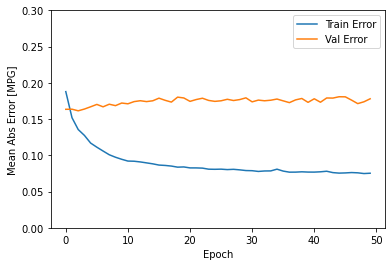

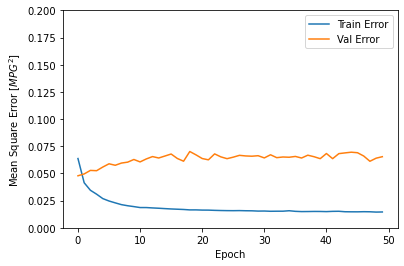

In [154]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.3])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0, 0.2])
  plt.legend()
  plt.show()


plot_history(history)

In [155]:
loss, mae, mse = model_2.evaluate(X_val, y_val, verbose=1)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

1216/1216 [==============================] - 0s 337us/sample - loss: 0.0654 - mae: 0.1780 - mse: 0.0654
Testing set Mean Abs Error:  0.18


In [156]:
test_2 = model_2.predict(X_val)

In [134]:
len(test_2[:,0])

1216

In [135]:
len(y_val.iloc[:,0])

1216

In [141]:
type(list(y_val.iloc[:,0]))

list

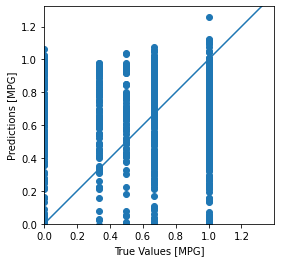

In [157]:
test_predictions = model_2.predict(X_val)

plt.scatter(x = y_val.iloc[:,2].values.flatten(), y = test_predictions[:,2].flatten())
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


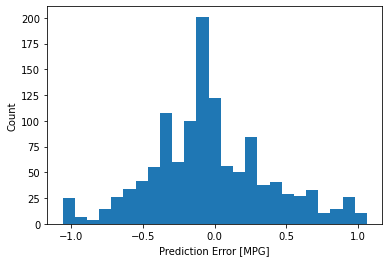

In [158]:
error = test_predictions[:,2].flatten() - y_val.iloc[:,2].values.flatten()
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

<a id="10.Unused Code"></a>
# 10.Unused Code
<a href="#1.Summary">Click this Link back to Top</a>

1.using question_user_page as benchmark, split quetsion_title or question_body into train_test, we believe different website have different type questions, so we can make evaluate and predict model

2.Using unsupervise learning to cluster question into differnt type, culster is depending on data preprocessing granularity. smaller grandularity, more spase cluster

3.After i embedding these sentence, you can use KNN SVM to do unsuperviese cluster

4.Using categore to cluster by CNN(n-gram / Glove / miniGPT）

5.Generage numerical value by former data and compart to anser_well_written

6.extract the root url like photo.stackchange.com to try to classfiy it with some argothrim, same question is to catgory column

7.If the result is not good enough, try to use url to grab more data to analysis

8.The data for this competition includes questions and answers from various StackExchange properties. Your task is to predict target values of 30 labels for each question-answer pair.

The list of 30 target labels are the same as the column names in the sample_submission.csv file. Target labels with the prefix question_ relate to the question_title and/or question_body features in the data. Target labels with the prefix answer_ relate to the answer feature.

9.for each dataframe maybe we need add category, and that will imporove performance

10.Stopword is meaningful for answer sequence, and so as punctuation. Try to only eliminate useless punctuatinon like '\`' but remain '?'and '!'
11.embedding is random initial word vector, but we can use Glove to import pretrain to impove performance

12.evalution part try to use BLEU score 

- https://www.tensorflow.org/tutorials/text/word_embeddings?hl=zh-cn
- https://towardsdatascience.com/nlp-building-a-question-answering-model-ed0529a68c54